<a href="https://colab.research.google.com/github/FirefoxSRV/GlassClassification/blob/main/GlassClassification_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
data = pd.read_csv("glass.csv")
X = data.drop("Type", axis=1)
y = data["Type"]

In [ ]:
print(X)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0
..       ...    ...   ...   ...    ...   ...   ...   ...  ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0

[214 rows x 9 columns]


In [ ]:
print(y)

0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: Type, Length: 214, dtype: int64


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
knn = KNeighborsClassifier()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

param_dist = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [ ]:

best_params = random_search.best_params_

best_knn = KNeighborsClassifier(metric=best_params['metric'],weights=best_params['weights'])

best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)
print("Best Hyperparameters:", best_params)

Accuracy: 0.8372093023255814
Best Hyperparameters: {'weights': 'distance', 'metric': 'manhattan'}


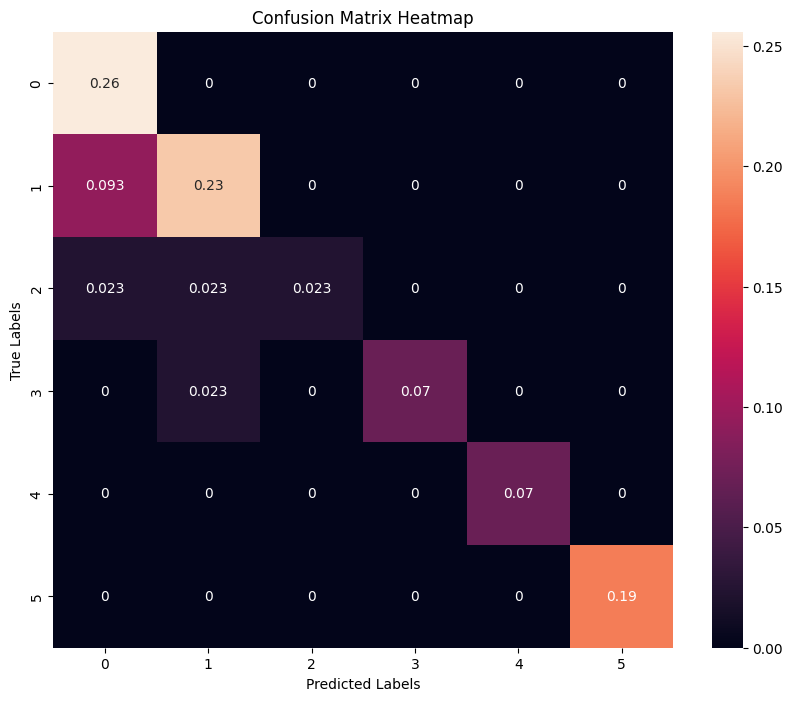

0.8372093023255814

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
accuracy_score(y_test, y_pred)

                                           params  mean_test_score  \
3  {'weights': 'distance', 'metric': 'manhattan'}         0.672605   
1  {'weights': 'distance', 'metric': 'euclidean'}         0.661008   
5  {'weights': 'distance', 'metric': 'minkowski'}         0.661008   
2   {'weights': 'uniform', 'metric': 'manhattan'}         0.637647   
0   {'weights': 'uniform', 'metric': 'euclidean'}         0.625882   
4   {'weights': 'uniform', 'metric': 'minkowski'}         0.625882   

   std_test_score  
3        0.033134  
1        0.049688  
5        0.049688  
2        0.026464  
0        0.026201  
4        0.026201  


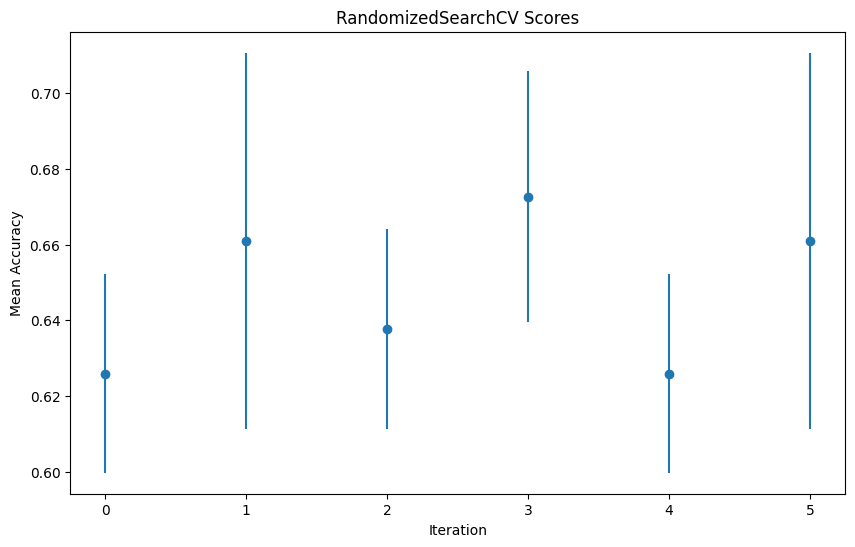

In [ ]:
# Visualize RandomizedSearchCV scores
results = pd.DataFrame(random_search.cv_results_)
scores = results[['params', 'mean_test_score', 'std_test_score']]
print(scores.sort_values(by='mean_test_score', ascending=False))

plt.figure(figsize=(10,6))
plt.errorbar(range(len(scores)), scores['mean_test_score'], yerr=scores['std_test_score'], fmt='o')
plt.title('RandomizedSearchCV Scores')
plt.xlabel('Iteration')
plt.ylabel('Mean Accuracy')
plt.show()


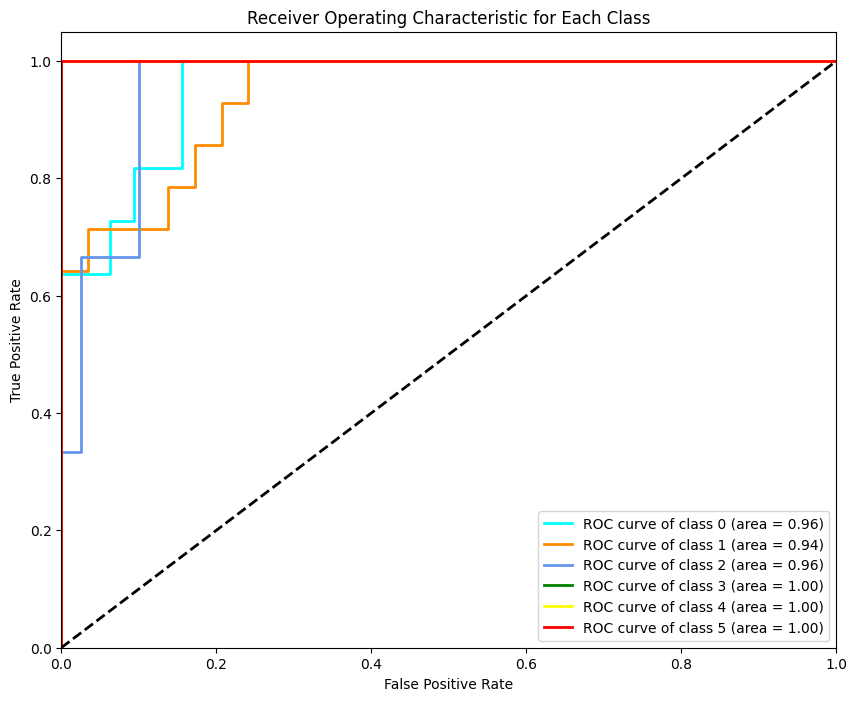

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=list(range(len(np.unique(y)))))
y_pred_prob = best_knn.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y))
lw = 2

plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'yellow', 'red', 'purple'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()



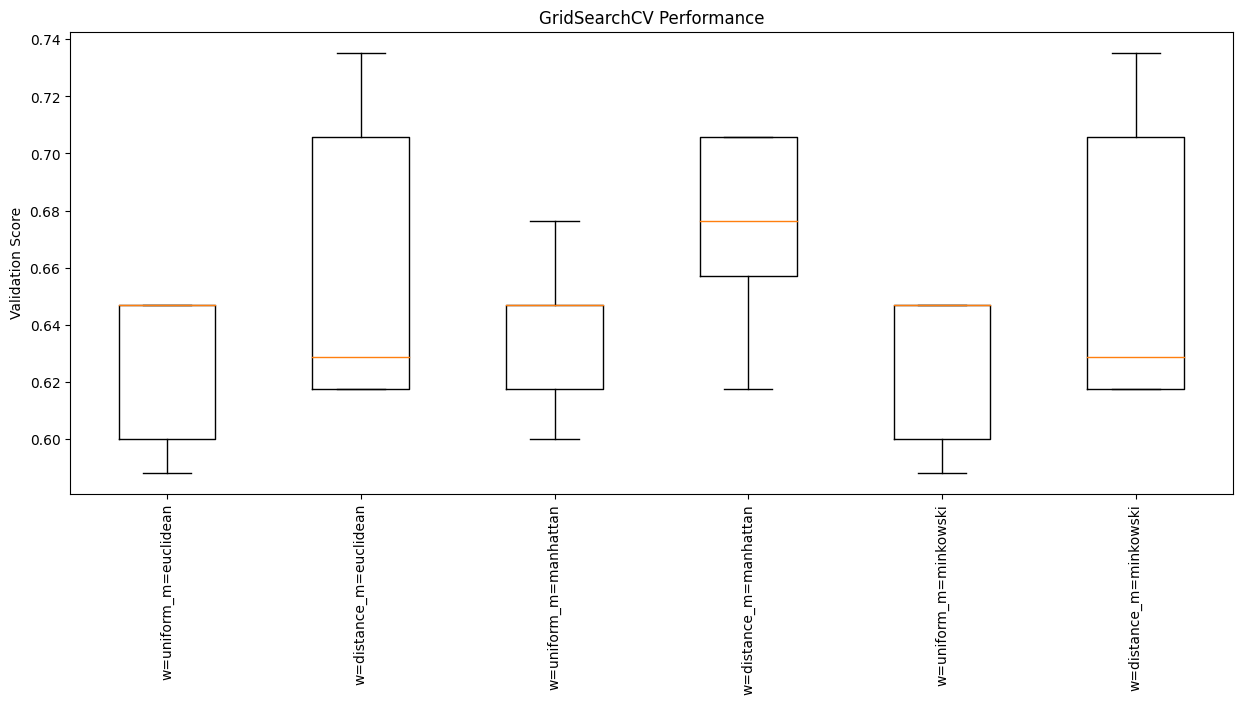

In [ ]:
results = random_search.cv_results_

# Extract scores for each parameter combination across the splits
all_test_scores = [results[f'split{i}_test_score'] for i in range(5)]
all_test_scores = list(zip(*all_test_scores))  # Transpose to get scores by parameter combination

# Create simplified labels for x-axis
param_combinations = ["_".join([f"{k[0]}={v}" for k, v in param.items()]) for param in results['params']]

plt.figure(figsize=(15, 6))
plt.title("GridSearchCV Performance")
plt.boxplot(all_test_scores, vert=True)
plt.xticks(np.arange(1, len(param_combinations) + 1), param_combinations, rotation=90)
plt.ylabel('Validation Score')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

Best Hyperparameters: {'weights': 'distance', 'metric': 'manhattan'}
Accuracy: 0.8372093023255814

Confusion Matrix:
[[11  0  0  0  0  0]
 [ 4 10  0  0  0  0]
 [ 1  1  1  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.83      0.71      0.77        14
           2       1.00      0.33      0.50         3
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         8

    accuracy                           0.84        43
   macro avg       0.92      0.80      0.82        43
weighted avg       0.87      0.84      0.83        43

